# Load and split the data

In [84]:
# Main imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from typing import List

# Models selections
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import RandomizedSearchCV

# Preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

# Impute values
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer

# Generate new values
from imblearn.over_sampling import SMOTE

# Column transforms
from sklearn.compose import make_column_selector
from sklearn.compose import ColumnTransformer

# Create Pipelines
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import Pipeline as IMBPipeline

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.inspection import permutation_importance

# Metrics
from sklearn.metrics import roc_auc_score

In [88]:
# Load the data
path = "data/WA_Fn-UseC_-Telco-Customer-Churn.csv"
data = pd.read_csv(path)

# Churn to boolean
data['Churn'].replace({'No': False, 'Yes': True}, inplace=True)

# TotalCharges to float
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')

# All objects to categorical type
data[data.select_dtypes(['object']).columns] = data.select_dtypes(['object'])\
                                                    .apply(lambda x: x.astype('category'))
data['SeniorCitizen'] = data['SeniorCitizen'].astype('category')

# Drop needless column
data.drop('customerID', axis=1, inplace=True)

# Form X and y data
X = data.drop('Churn', axis=1)
y = data['Churn']

# Form train and validate dataset
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

In [89]:
X_train.sample(5)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
744,Female,0,No,No,5,Yes,No,DSL,No,No,No,No,No,No,Month-to-month,Yes,Credit card (automatic),44.05,202.15
2916,Male,0,No,No,51,No,No phone service,DSL,Yes,No,No,Yes,No,Yes,Month-to-month,Yes,Credit card (automatic),44.45,2181.55
6581,Female,1,No,No,54,Yes,Yes,DSL,No,Yes,No,Yes,Yes,No,One year,No,Mailed check,72.10,3886.05
5320,Male,0,No,Yes,37,Yes,No,DSL,Yes,Yes,No,Yes,No,No,Two year,No,Credit card (automatic),61.45,2302.35
5892,Male,0,No,No,10,Yes,No,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Mailed check,51.65,524.50


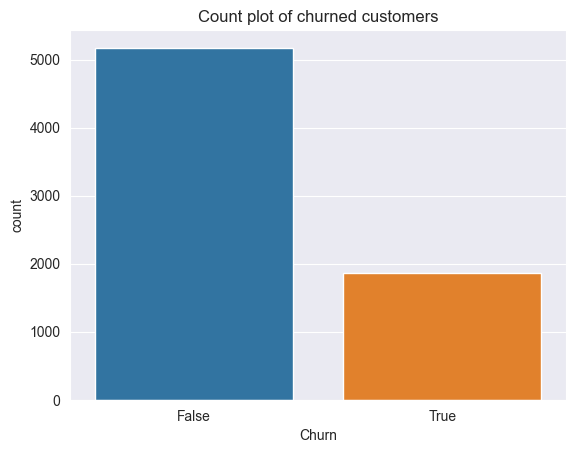

In [90]:
plt.title("Count plot of churned customers")
sns.countplot(data, x='Churn', );

# Preprocessing

Steps:
1. Impute missing values
2. OneHot encode categorical values

In [91]:
class columnDropperTransformer():
    """Function for Pipeline to drop needless columns"""
    def __init__(self,columns: List[str]):
        self.columns=columns

    def transform(self,X,y=None):
        return X.drop(self.columns, axis=1)

    def fit(self, X, y=None):
        return self 

In [92]:
# Pick only numerical columns
numerical_columns = make_column_selector(dtype_include=np.number)
# Pick only categorical columns
categorical_columns = make_column_selector(dtype_include='category')

# Define preprocess for numerical features
numerical_transformer = make_pipeline(
    SimpleImputer(strategy='mean'), 
    MinMaxScaler()
)
# Define preprocess for categorical features
categorical_transformer = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(sparse=False, handle_unknown='ignore')
)

# Tie it all together
preprocessing = ColumnTransformer([
    # Step 2: impute and preprocess
    ('numerical_transform', numerical_transformer, numerical_columns),
    # Step 3: OneHot Encode and preprocess
    ('categorical_transform', categorical_transformer, categorical_columns)
])


In [93]:
pipe = Pipeline([
    # Preprocess features
    ('preprocessing', preprocessing)
])

### Extract transformed and scaled features from the pipeline

In [94]:
pipe.fit(X_train, y_train)
features = pd.Series(pipe.get_feature_names_out())
features

0                           numerical_transform__tenure
1                   numerical_transform__MonthlyCharges
2                     numerical_transform__TotalCharges
3                  categorical_transform__gender_Female
4                    categorical_transform__gender_Male
5                categorical_transform__SeniorCitizen_0
6                categorical_transform__SeniorCitizen_1
7                     categorical_transform__Partner_No
8                    categorical_transform__Partner_Yes
9                  categorical_transform__Dependents_No
10                categorical_transform__Dependents_Yes
11               categorical_transform__PhoneService_No
12              categorical_transform__PhoneService_Yes
13              categorical_transform__MultipleLines_No
14    categorical_transform__MultipleLines_No phone ...
15             categorical_transform__MultipleLines_Yes
16           categorical_transform__InternetService_DSL
17    categorical_transform__InternetService_Fib

### Define models

In [95]:
logreg = LogisticRegression(warm_start=True, max_iter=1000)
booster = HistGradientBoostingClassifier()
naive = GaussianNB()

voter = VotingClassifier(estimators=[
    ('logreg', logreg),
    ('booster', booster),
    ('naive', naive)
], voting='soft')

# Build pipeline using IMBlearn

In [97]:
imbpipe = IMBPipeline([
    # 1. Preprocess features
    ('preprocessing', preprocessing),
    # 2. Generate new data
    ('smote', SMOTE()),
    # 3. Use voter model
    ('ensemble', voter)
])

In [98]:
imbpipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('numerical_transform',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f8fdc6cad90>),
                                                 ('categorical_transform',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f8fdce07190>)])),
                ('smote', SMOTE()),
                ('ensemble',
                 VotingClassifier(estimators=[('logreg',
                                               LogisticRegression(max_iter=1000,
                                                                  warm_start=True)),
                                              ('booster',
                                               HistGradientBoostingClassifier()),
                                              ('naive', GaussianNB())],
                                  voting='soft'))])

# Hyperparameter tuning

In [104]:
params = {
    'ensemble__logreg__solver': ['newton-cg', 'lbfgs'],
    'ensemble__logreg__penalty': ['l1', 'l2'],
    'ensemble__logreg__C': [1e-5, 1e-3, 10],
    'ensemble__booster__learning_rate': [1e-5, 1e-3, 1e-1],
    'ensemble__booster__max_iter': [100, 200],
    'ensemble__booster__max_depth': [5, 10],
    'ensemble__booster__l2_regularization': [0, 1]
}

rep_folds = RepeatedStratifiedKFold(random_state=42)

random_search_model = RandomizedSearchCV(
    estimator=imbpipe,
    param_distributions=params,
    scoring='roc_auc',
    cv=rep_folds,
    n_jobs=-1,
    verbose=1
)

random_search_model.fit(X_train, y_train)

print("[INFO] Best Score: ", random_search_model.best_score_)
print("[INFO] Best Parameters: ", random_search_model.best_params_)
print("[INFO] ROC-AUC score: ", roc_auc_score(y_val, random_search_model.predict(X_val)))

Fitting 50 folds for each of 10 candidates, totalling 500 fits


/Users/administrator/opt/miniconda3/envs/analyst/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
150 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
100 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/administrator/opt/miniconda3/envs/analyst/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/administrator/opt/miniconda3/envs/analyst/lib/python3.8/site-packages/imblearn/pipeline.py", line 272, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/Users/administrator/opt/miniconda3/envs/ana

[INFO] Best Score:  0.8424489026298868
[INFO] Best Parameters:  {'ensemble__logreg__solver': 'lbfgs', 'ensemble__logreg__penalty': 'l2', 'ensemble__logreg__C': 10, 'ensemble__booster__max_iter': 100, 'ensemble__booster__max_depth': 5, 'ensemble__booster__learning_rate': 0.1, 'ensemble__booster__l2_regularization': 0}
[INFO] ROC-AUC score:  0.7624600057227584


In [100]:
def plot_feature_importance(results, features):
    fig, ax = plt.subplots()
    indices = results['importances_mean'].argsort()
    
    plt.barh(range(len(indices)),
        results['importances_mean'][indices],
        xerr=results['importances_std'][indices]
        )

    ax.set_yticks(range(len(indices)))
    ax.set_title("Permutation importance")

    tmp = np.array(features)
    _ = ax.set_yticklabels(tmp[indices])
    return


In [101]:
pipe_features = imbpipe[0]
pipe_features.fit(X_train, y_train)
features = pipe_features.get_feature_names_out()

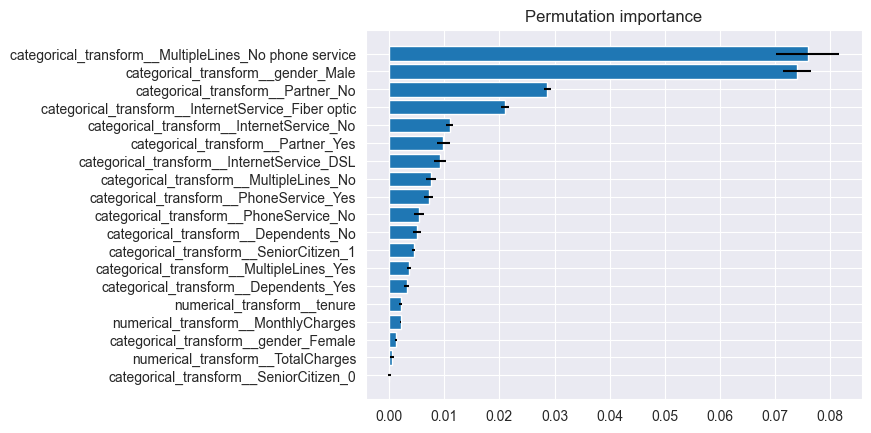

In [103]:
importance_results = permutation_importance(random_search_model, X_train, y_train, random_state=42, n_jobs=-1)
plot_feature_importance(importance_results, features)

# Conclusions:

As we can see, the most importance features is: MultipleLines, Gender, Partner, InternetService and PhoneService. The other features not really much influence our data. So we can conclude, that the male customer, that doesn't use phone service, who's not a partner for us and who's not using Internet service in most cases will leave the company.